In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.autolayout'] = True

plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['font.size'] = 8
from datetime import datetime
import matplotlib as mpl

%matplotlib inline


In [2]:
### READ IN WATER ISOTOPE DATA
df = pd.read_csv('../Data/isotope-data.csv',
                 sep=',',  skiprows = [1])
df['Time Collected'] = df['Time Collected'].fillna('12:00')
df['datetime'] = pd.to_datetime(df['Date Collected']+ ' ' + df['Time Collected'])
df['date'] = pd.to_datetime(df['Date Collected'])

startDateTime = pd.to_datetime('2016-01-01 00:00:00')
stopDateTime = pd.to_datetime('2017-01-01 00:00:00')


df = df[(df['datetime'] > startDateTime) &
                                (df['datetime'] < stopDateTime)] 


sagehornOaks = df[df['Species (scientific)']=='QUGA']

sagehornGW = df[df['Sample Type II'] == 'Well water']
sagehornGW = sagehornGW[(sagehornGW['Location'] == 'MN1') | 
                      (sagehornGW['Location'] == 'MN-1') |
                      (sagehornGW['Location'] == 'MS4') |
                      (sagehornGW['Location'] == 'MS-4')|
                      (sagehornGW['Location'] == 'W507')]

stems = sagehornOaks[sagehornOaks['Sample Type II']=='Stem']

stems['Adjacent well groundwater depth at time of sampling (m)'].replace({'>2': '2'}, regex=True, inplace=True)


/Users/wjh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [3]:
# GROUP WATER ISOTOPE BY SAMPLE DAY

stemsGroup = stems.groupby(['date'])

stemsMeans = stemsGroup.agg({'dD' : 'mean', 
                    'dO' : 'mean'})
stemsStds  = stemsGroup.agg({'dD' : 'std', 
                    'dO' : 'std'})


In [4]:
stemsMeans

,dD,dO
date,,
2016-05-05,-48.457143,-6.988571
2016-05-19,-54.560000,-7.978000
2016-06-11,-55.328571,-8.022857
2016-06-22,-56.057143,-8.175714
2016-07-24,-59.971429,-8.667143
2016-08-26,-61.800000,-8.765000
2016-09-17,-60.842857,-8.657143
2016-11-01,-48.050000,-7.070000


In [5]:
gwGroup = sagehornGW.groupby(['date'])

gwMeans = gwGroup.agg({'dD' : 'mean', 
                    'dO' : 'mean'})
gwStds  = gwGroup.agg({'dD' : 'std', 
                    'dO' : 'std'})


In [6]:
merged = gwMeans.merge(stemsMeans,suffixes=('_gw','_stems'),left_index=True,right_index=True)
merged.head()

,dD_gw,dO_gw,dD_stems,dO_stems
date,,,,
2016-05-19,-43.1,-7.25,-54.560000,-7.978000
2016-06-22,-42.3,-7.10,-56.057143,-8.175714
2016-08-26,-43.1,-7.08,-61.800000,-8.765000
2016-09-17,-44.1,-7.14,-60.842857,-8.657143
2016-11-01,-35.6,-6.04,-48.050000,-7.070000


In [7]:
### READ IN WATER POTENTIAL DATA
potential = pd.read_csv('../Data/waterpotentials.csv',
                 sep=',')
potential = potential[potential['AGE']=='MATURE']
potential = potential[potential['WHAT MEASURED']=='SHOOT']
potential['date'] = pd.to_datetime(potential['DATE COLLECTED'])
potentialSagehorn = potential[potential['SITE']=='SAGEHORN']
potentialSagehornOaks = potentialSagehorn[potentialSagehorn['SPECIES (sci)']=='QUGA']
predawn = potentialSagehornOaks[potentialSagehornOaks['TIME OF DAY']=='pre-dawn']
predawn = predawn[predawn.TREE != 'car park big oak']
predawn = predawn[predawn.TREE != 'NT']

In [8]:
# GROUP WATER POTENTIAL BY SAMPLE DAY, TREE
### MEAN
#group by the date then tree
groupDateTree = predawn.groupby(['date', 'TREE'])
meansPredawn = groupDateTree.agg({'PRESSURE [MPa]' : 'mean'})
meansPredawn = meansPredawn.reset_index()
#then group again by date
groupDate = predawn.groupby(['date'])
meansPredawn = groupDate.agg({'PRESSURE [MPa]' : 'mean'})

### STD
#group by the date then tree
stdsPredawn = groupDateTree.agg({'PRESSURE [MPa]' : 'std'})
stdsPredawn = meansPredawn.reset_index()
#then group again by date
groupDate = predawn.groupby(['date'])
stdsPredawn = groupDate.agg({'PRESSURE [MPa]' : 'std'})


In [9]:
meansPredawn

,PRESSURE [MPa]
date,
2015-09-01,2.658333
2015-09-27,2.570000
2016-05-04,0.359375
2016-05-19,0.373077
2016-06-11,0.530000
2016-06-23,0.744118
2016-07-25,0.942500
2016-08-26,2.561765
2016-09-17,2.892353


In [10]:
merged = pd.merge_asof(meansPredawn,stemsMeans, left_index=True, right_index=True, tolerance=pd.Timedelta('3D'),direction='nearest') 
mergedstds=pd.merge(stemsStds, stdsPredawn, left_index=True, right_index=True, how='outer') 


In [11]:
merged = merged.dropna()
merged

,PRESSURE [MPa],dD,dO
date,,,
2016-05-04,0.359375,-48.457143,-6.988571
2016-05-19,0.373077,-54.560000,-7.978000
2016-06-11,0.530000,-55.328571,-8.022857
2016-06-23,0.744118,-56.057143,-8.175714
2016-07-25,0.942500,-59.971429,-8.667143
2016-08-26,2.561765,-61.800000,-8.765000
2016-09-17,2.892353,-60.842857,-8.657143
2016-11-01,0.000000,-48.050000,-7.070000


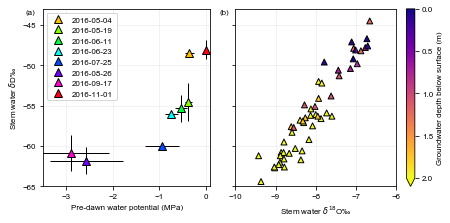

In [12]:
#DEUTERIUM ONLY
plt.rcParams['font.size'] = 8

fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=((16/2.54),(8/2.54)),
                               gridspec_kw={'width_ratios':[1,1.2]})

days = sorted((set(merged.index)))
cNorm  = colors.Normalize(vmin=0, vmax=(len(days)))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') ) #_r reverses cmap


for day in days:
    thisDay = merged[merged.index==day]
    thisDayErrors = mergedstds[mergedstds.index==day]
    ax0.errorbar(-thisDay['PRESSURE [MPa]'], thisDay['dD'],
             xerr=-thisDayErrors['PRESSURE [MPa]'], yerr=-thisDayErrors['dD'],
            fmt='^', 
                 label=day.date(),
                 c=colors.rgb2hex(scalarMap.to_rgba((days.index(day))+1)), #alpha=0.8,
                 ecolor='k', capsize=0, elinewidth=1,ms=8, zorder=100,mew=1,mec='black')

ax0.set_ylabel(r'Stem water $\delta$D' + u'\u2030')

# get handles
handles, labels = ax0.get_legend_handles_labels()
# # remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
ax0.legend(handles, labels, loc = 'upper left', fontsize=8, #bbox_to_anchor = (0.2,0.2,1,1),
             frameon=True, numpoints = 1, markerscale=1.)

ax0.set_ylim([-65,-43])
ax0.set_yticks(np.arange(-65, -40, 5.0))

ax0.grid(alpha=0.2)

ax0.set_xlabel('Pre-dawn water potential (MPa)')
ax0.set_xlim([-3.5,0.1])

### stem dD vs dO by GW depth
plt.rcParams['font.size'] = 8

ax1.scatter(stems.dO, stems.dD,
            c=stems['Adjacent well groundwater depth at time of sampling (m)'].astype(float),
            cmap = plt.cm.get_cmap('plasma'),
            vmin=0,
            vmax=2, 
            alpha=1,
            marker='^',
            s=35, edgecolor='k')

cax=plt.gca() #get the current axes
PCM=cax.get_children()[0] 
cb = plt.colorbar(PCM, ax=cax, extend='max',label='Groundwater depth below surface (m)')

m0=float(0)            # colorbar min value
m4=float(2)             # colorbar max value
m1=float(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=float(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=float(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cb.set_ticks([m0,m1,m2,m3,m4])
cb.set_ticklabels([m0,m1,m2,m3,m4])

plt.ylim([-65,-43])
plt.yticks(np.arange(-65, -40, 5.0))
plt.xlim([-10,-6])
cb.ax.invert_yaxis()
plt.grid(alpha=0.2)
# cb.set_ylabel('Groundwater depth below surface (m)')
plt.xlabel(r'Stem water $\delta^{18}$O' + u'\u2030')
# plt.ylabel(r'Stem water $\delta$D' + u'\u2030')


ax0.text(-.1, 1, '(a)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax0.transAxes,
        color='black', fontsize=8)
ax1.text(-.1, 1, '(b)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax1.transAxes,
        color='black', fontsize=8)


fig.savefig('../Figs/dD-vs-predawn-dDvsdObyGWdepth.pdf', bbox_inches='tight')